# **Prostate Cancer Classification: Logistic Regression vs Decision Tree**

The purpose of this project is to train a classifier which would succesfully classify prostate cancer tumours as benign or malignant, based on a set of numerical features. In our case we decided to train two classifiers - Logistic Regression and Decision tree and then compare their performance.

## **Data**

### **Data Description**

The data consists of 100 samples with diagnosis of benign and malignant tumour. There are 10 features in the original dataset:\
1.id\
2.diagnosis_result\
3.Radius\
4.Texture\
5.Perimeter\
6.Area\
7.Smoothness\
8.Compactness\
9.Symmetry\
10.Fractal dimension

Now, the ***id*** just assigns a unique number to each sample and thus does not add any useful information. Thus, it will be dropped from the feature matrix. In addition, ***diagnosis_result*** is the target variable, taking two values - "B" (benign) and "M" (malignant). Thus, this variable will be dropped from the feature matrix and stored separately as the outcome to be predicted.
Thus we are left with 8 features in total.

### **Data Loading**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install scikit-optimize

In [3]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import skopt 
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [4]:
# Load data
df = pd.read_csv("/content/gdrive/My Drive/MLProjects/ProstateCancerClassifier/Prostate_Cancer.csv")


### **Exploratory Data Analysis**

The first thing worth looking at is whether the dataset is balanced.

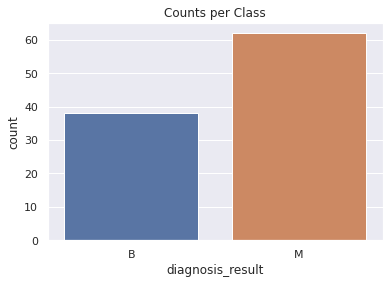

In [5]:
# Proportion of Benign and Malignant samples
# check numbers of samples in both conditions (B and M), to see if they are balanced
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = "diagnosis_result", data = df, order = ["B", "M"]).set_title("Counts per Class")




As one can see, the ratio of benign to malignant samples is roughly 2:3. This imbalance should be taken into account when splitting the dataset into train and test, as well as in evaluation. 

It is interesting to check whether there is a difference in the distribution of feature values in the two groups

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


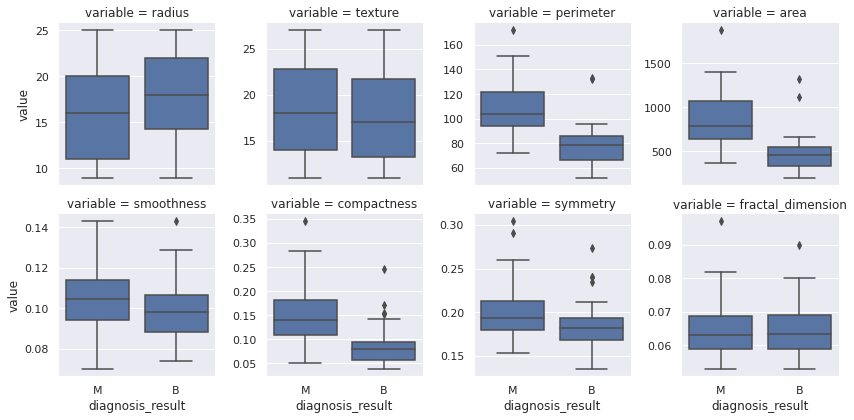

In [6]:
df_plot = df.melt(id_vars=['id', 'diagnosis_result'])
cols = df.columns
grid = sns.axisgrid.FacetGrid(df_plot[df_plot.variable.isin(cols)], col='variable', sharey=False, col_wrap = 4)
grid.map(sns.boxplot, 'diagnosis_result','value')

At first sight, there appears to be a noticeable difference of the values of ***perimeter, area,*** and ***compactness*** between the 'benign' and 'malignant' group. The rest of the variables do not seem to exhibit difference in the distribution of values, when split by diagnosis.

In [7]:
# summary of variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,100.0,50.50000,29.011492,1.000,25.7500,50.5000,75.250,100.000
radius,100.0,16.85000,4.879094,9.000,12.0000,17.0000,21.000,25.000
texture,100.0,18.23000,5.192954,11.000,14.0000,17.5000,22.250,27.000
perimeter,100.0,96.78000,23.676089,52.000,82.5000,94.0000,114.250,172.000
area,100.0,702.88000,319.710895,202.000,476.7500,644.0000,917.000,1878.000
smoothness,100.0,0.10273,0.014642,0.070,0.0935,0.1020,0.112,0.143
compactness,100.0,0.12670,0.061144,0.038,0.0805,0.1185,0.157,0.345
symmetry,100.0,0.19317,0.030785,0.135,0.1720,0.1900,0.209,0.304
fractal_dimension,100.0,0.06469,0.008151,0.053,0.0590,0.0630,0.069,0.097


As one can see the variables are on different scales, hence a normlization or standardization is required.

In order to decide on whether to normalize or standardize, it is worth looking at the distributions of the variables.


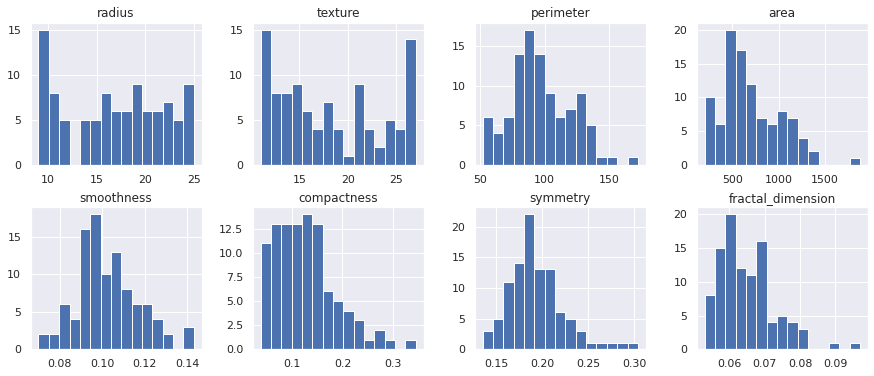

In [8]:
# check feature distributions
cols = df.columns[2:]
df[cols].hist(bins=15, figsize=(15, 6), layout=(2, 4));

As one can see, the variables are not normally distributed, thus, normalizing is probably a more reasonable option than standardizing, as the latter is based on the assumption that the variables are normally distributed. While some claim that standradization is fairly robust to the violation to this assumption, we still decide to stick with normalization.

### **Data Processing**

First we want to extract the labels from the feature matrix and also drop the id column, as it doesn't carry any useful information.

In [9]:
# Extract Class Labels
y = df['diagnosis_result']
# transform the string categories into numbers
y = y.replace("B", 0)
y = y.replace("M", 1)

In [10]:
# drop labels from feature matrix
df = df.drop('diagnosis_result', axis = 1)

# drop id column
df = df.drop('id', axis = 1)

# rename dataframe for easier use
X = df


When splitting the dataset we also ensure the split is stratified, meaning that we ensure that the proportion of benign to malignant samples is roughly the same in the train and test sets.

#### **Splitting the Dataset**

In [11]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_test.head()

(75, 8)
(75,)
(25, 8)
(25,)


,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
13,12,22,104,783,0.084,0.100,0.185,0.053
39,10,14,88,559,0.102,0.126,0.172,0.064
41,19,27,72,371,0.123,0.122,0.190,0.069
63,24,17,59,261,0.077,0.088,0.234,0.070
0,23,12,151,954,0.143,0.278,0.242,0.079


#### **Data Normalization**

In [12]:
# Normalize each feature
scaler = MinMaxScaler()

# scale only the numerical features
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.head()



,0,1,2,3,4,5,6,7
0,0.6250,0.9375,0.350000,0.266110,0.338028,0.247967,0.431953,0.068182
1,0.5625,0.8750,0.375000,0.304893,0.295775,0.134146,0.159763,0.090909
2,1.0000,0.2500,0.200000,0.140811,0.183099,0.040650,0.307692,0.181818
3,0.6250,0.8750,0.191667,0.134845,0.225352,0.048780,0.088757,0.136364
4,0.1250,0.6875,0.608333,0.528640,0.507042,0.613821,0.491124,0.204545


In [13]:
# normalizing the test set

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7
0,0.1875,0.6875,0.489130,0.498152,0.106061,0.201954,0.320513,0.000000
1,0.0625,0.1875,0.315217,0.291128,0.378788,0.286645,0.237179,0.297297
2,0.6250,1.0000,0.141304,0.117375,0.696970,0.273616,0.352564,0.432432
3,0.9375,0.3750,0.000000,0.015712,0.000000,0.162866,0.634615,0.459459
4,0.8750,0.0625,1.000000,0.656192,1.000000,0.781759,0.685897,0.702703
5,0.7500,1.0000,0.771739,0.886322,0.727273,0.397394,0.461538,0.189189
6,0.1875,0.1250,0.010870,0.023105,0.409091,0.130293,0.237179,0.432432
7,0.1250,0.0000,0.750000,0.794824,0.212121,0.589577,0.615385,0.270270
8,0.4375,0.7500,0.521739,0.520333,0.409091,0.384365,0.416667,0.324324
9,0.4375,0.4375,0.923913,0.925139,0.787879,1.000000,1.000000,0.756757


Note that we rescale the train and test set separately, as doing this before splitting them is claimed to possibly result in data leakage. Now, before proceeding to model fitting, we will briefly discuss the evaluation metric that we chose.


## **Choosing an Evaluation Metric**

In order to pick a good evaluation metric, we need to first clarify what the goal of our classifier is. In the case of classifying prostate tumours as benign or malignant, we would like to put more emphasis on the identification of malignant tumours. The reason for this is because if we misclassify a malignant tumour as benign, this could potentially have a fatal outcome for the patient. What is more, we would want to make sure both that of all samples classified as 'malignant', a high percentage would actually be malignant. This is, we require a **high precision** score. In addition, we want to ensure that given all malignant tumours, most of them are successfully classified as malignant. This is, we also need a **high recall** score. A good way to **combine precision and recall** is by using the **F1-score**.
Thus, we choose F1-score, in order to ensure that the model we select would have both adequate precision and recall.

## **Model Fitting**

As mentioned earlier, in this project we decided to use a Logistic regression and a Decision tree classifier and compare their performance. Now, in order to have a baseline to compare the performance of our models to, after we tune their parameters, we would first fit them both with their default parameters.

In [14]:
#Compare algorithms in their default configurations
from sklearn.pipeline import Pipeline

models = [LogisticRegression(),DecisionTreeClassifier()]
scaler = MinMaxScaler()

model_names = [type(x).__name__ for x in models]
std_score = []
for m in tqdm(models):
    pipeline = Pipeline([('transformer', scaler), ('estimator', m)])
    std_score.append(cross_val_score(pipeline,
                                 X = X,
                                 y = y,
                                 scoring = 'f1',
                                 cv = 10).mean())
    
pd.Series(data = std_score, index = model_names)

100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


LogisticRegression        0.902639
DecisionTreeClassifier    0.775861
dtype: float64

As one can see, Logistic Regression already has a very reasonable mean F1-score, while the Decision Tree classifier has some room for improvement. We are now proceeding with fitting Logistic Regression and Decision Tree classifier, conducting Bayesian Optimization and Grid Search for hypertuning some of the parameters, respectively.

### **Logistic Regression**

#### **Hyperparameter Tuning with Bayesian Optimization**

In order to try and get an optimal performance out of our logistic regression algorithm, we need to tune the hyperparameters. In this case we will use Bayesian optimization.


In [15]:
import skopt 
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

scoring = {'f1': make_scorer(f1_score, average='binary')}
lr_params = { 'solver': ['liblinear', 'lbfgs'],  
              'tol': skopt.space.Real(1e-5, 1e-3, 'uniform'),
              'C': skopt.space.Real(1e-5, 10, 'uniform'),
              'fit_intercept': [True, False],
              'max_iter': skopt.space.Integer(1000, 2000, 'uniform')
}

bayes = BayesSearchCV(LogisticRegression(dual = False), search_spaces = lr_params, n_iter = 100, scoring='f1', cv=5, random_state=0)
res = bayes.fit(X_train, y_train)
print(res.best_params_)


OrderedDict([('C', 5.309646339879824), ('fit_intercept', True), ('max_iter', 1623), ('solver', 'liblinear'), ('tol', 0.0008601563933385878)])


#### **Training the Best Model**

In [16]:
model_lr = LogisticRegression(C = 5.309646339879824, fit_intercept = True, max_iter = 1623, solver = 'liblinear', tol = 0.0008601563933385878, dual = False).fit(X_train, y_train)

#### **Model Evaluation**

In [17]:
# Generate predictions for test samples
y_pred = model_lr.predict(X_test)
y_pred

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1])

In [18]:
# Calculate model performance metrics on test set

print(f1_score(y_test, y_pred, average = 'binary'))
print()
print("F1-score for each label")
print()
print("  B           M")
print(f1_score(y_test, y_pred, average = None))


0.9032258064516129

F1-score for each label

  B           M
[0.84210526 0.90322581]


As one can see, hyperparameter tuning has barely changed the predictive performance of the algorithm on the test set. As one can see from the F1-score, the model performs reasonably well in classifying both classes.

### **Decision Tree**

### **Hyperparameter Tuning using GridSearch**

In [19]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'criterion': ['gini', 'entropy'],  
                   'splitter': ['best', 'random'],
                  'max_features':['auto', 'sqrt', 'log2', None],
                  'max_depth': range(2,20),
                  }
scoring = {'f1': make_scorer(f1_score, average='binary')}
model_dt = GridSearchCV(DecisionTreeClassifier(random_state = 0), tuned_parameters, scoring = scoring, refit = 'f1')
model_dt.fit(X_train, y_train)
print("Best parameters set through GridSearchCV")
print()
print(model_dt.best_params_)


Best parameters set through GridSearchCV

{'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'splitter': 'random'}


In [20]:
model_dt = DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = None, max_depth = 3, random_state = 0).fit(X_train, y_train)


In [21]:
# Generate predictions for test samples
y_pred = model_dt.predict(X_test)
y_pred

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1])

In [22]:
# Calculate model performance metrics on test set

print(f1_score(y_test, y_pred, average = 'binary'))
print()
print("F1-score for each label")
print()
print("  B           M")
print(f1_score(y_test, y_pred, average = None))


0.8823529411764706

F1-score for each label

  B           M
[0.75       0.88235294]


As one can see, the performance of the Decision Tree classifier performs better than the DT classifier with default parameters. It does however perform slightly worse than the tuned Logistic Regression model, in terms of the F1-score for benign samples.

### **Logistic Regression Classifier with a Reduced Number of Features**

Now, earlier on in our Exploratory Data Analysis section we saw that there were four variables, which appeared to have different distributions of their values when split by classes. These were ***perimeter, area, compactness*** and ***symmetry***. An interesting experiment would be to see how well a classifier only trained using these four features would perform in classifying prostate cancer tumours.

In [23]:
X_train_small = X_train[[2, 3, 5, 6]]
X_test_small = X_test[[2, 3, 5, 6]]

In [24]:
import skopt 
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

scoring = {'f1': make_scorer(f1_score, average='binary')}
lr_params = { 'solver': ['liblinear', 'lbfgs'],  
              'tol': skopt.space.Real(1e-5, 1e-3, 'uniform'),
              'C': skopt.space.Real(1e-5, 10, 'uniform'),
              'fit_intercept': [True, False],
              'max_iter': skopt.space.Integer(1000, 2000, 'uniform')
}

bayes = BayesSearchCV(LogisticRegression(dual = False), search_spaces = lr_params, n_iter = 100, scoring='f1', cv=5, random_state=0)
res = bayes.fit(X_train_small, y_train)
print(res.best_params_)


OrderedDict([('C', 2.583724036010862), ('fit_intercept', True), ('max_iter', 1908), ('solver', 'liblinear'), ('tol', 0.00026989901347836977)])


In [25]:
model_lr = LogisticRegression(C = 2.583724036010862, fit_intercept = True, max_iter = 1908, solver = 'liblinear', tol = 0.00026989901347836977, dual = False).fit(X_train_small, y_train)

In [26]:
# Generate predictions for test samples
y_pred = model_lr.predict(X_test_small)
y_pred

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1])

In [27]:
# Calculate model performance metrics on test set

print(f1_score(y_test, y_pred, average = 'binary'))
print()
print("F1-score for each label")
print()
print("  B           M")
print(f1_score(y_test, y_pred, average = None))


0.8749999999999999

F1-score for each label

  B           M
[0.77777778 0.875     ]


As one can see, the classifier performs slightly more poorly, compared to the logistic regression trained on all 8 features. But since we only have one test set, it is not very clear whether this difference is statistically significant. Thus, in case extra test data is obtained, it would be an interesting question to investigate.

## **Conclusion**

It seems like both classifiers do reasonably well in prostate cancer classification. While hypertuning of parameters didn't seem to improve the logistic regression classifier, it appeared to result in a significant improvement of malignant samples classification by the Decision tree classifier.
It also seems like a logistic regression classifier trained only with four of the original eight features - perimeter, area, compactness, and symmetry - performs almost on par with the above two. Extra test data would potentially clarify which one of the three models would be the best one to use.